# Baseline modeling

VERSION INFO:
- training done on new and final data split, which now considers disjointness of datasets with respect to the sites
- this time all samples are used for training
- the image resizing is change to resize to the biggest single-axis image shape present in the data sets (that is shape (540, 960, 3))
- the training is extended for model performance optimization by means of (without additional measures like regularization)
  - more training epochs
  - data augmentation

GENERAL INFO:
- target model: simple multinomial logistic regression
- implementation approach: single-layer neural network with softmax (i.e. categorical cross entropy) activation
- preprocessing:
  - different methods possible
  - at this point, a simple brute-force reshaping to the maximum image shape (max(height), max(width)) present in the data is performed to achieve a uniform input shape
  - the model could be enhanced by data augmentation, but not done here because the architecture is trivial anyway

## Imports

In [5]:
import sys
import os
import glob

import datetime as dt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

# cyberpunk theme
import mplcyberpunk
plt.style.use('cyberpunk')


import cv2 as cv

from sklearn.model_selection import train_test_split


import tensorflow as tf
import tensorflow.keras as keras




# project-specific custom functions
## export the path to custom modules
sys.path.append("../functions")
## import functions
from data_loading import load_data, get_label_name_from_filename

# keras.clear_session() # clear the cache of model parameters

## Define data directories

In [6]:
dir_data_base__relative = "../data/dataset_split_categories/"  # the relative directory path to all data files
dir_data_train = dir_data_base__relative+"train"
dir_data_val = dir_data_base__relative+"validation"
dir_data_test = dir_data_base__relative+"test"

## Instantiate the TF Dataset objects

In [7]:
RSEED = 42

# IMG_SIZE_height, IMG_SIZE_width = 200, 200
IMG_SIZE_height, IMG_SIZE_width = 540, 960  # shape is chosen according to the maximum image height and width present in the data
BATCH_SIZE = 64
# BATCH_SIZE = 32

dataset_train = keras.utils.image_dataset_from_directory(
    dir_data_train,
    labels="inferred",
    label_mode = "categorical",
    image_size = (IMG_SIZE_height, IMG_SIZE_width),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=RSEED,
    pad_to_aspect_ratio=True
)



dataset_validation = keras.utils.image_dataset_from_directory(
    dir_data_val,
    labels="inferred",
    label_mode = "categorical",
    image_size = (IMG_SIZE_height, IMG_SIZE_width),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=RSEED,
    pad_to_aspect_ratio=True
)

# this had been working:
dataset_test = keras.utils.image_dataset_from_directory(
    dir_data_test,
    labels="inferred",
    label_mode = "categorical",
    image_size = (IMG_SIZE_height, IMG_SIZE_width),
    batch_size = BATCH_SIZE,
    shuffle = False,  # shuffling test data is not necessary
    # shuffle = False,
    seed=RSEED,
    pad_to_aspect_ratio=True
)


Found 12955 files belonging to 8 classes.
Found 1647 files belonging to 8 classes.
Found 1886 files belonging to 8 classes.


In [21]:
data_info__all = pd.read_csv("../data/data_info__all.csv")  # DataFrame containing all file info (including the labels)
# labels = Y_test_df.columns.to_list()
labels = data_info__all.loc[:, "antelope_duiker":].columns.to_list()

## Model training

In [32]:
# instantiate the model
model = keras.Sequential(
    [
        keras.layers.Rescaling(scale=1./255, offset=0.0),  # rescale all pixel values to the [0, 1] range
        keras.layers.Flatten(),
        keras.layers.Dense(units=8,  # 8 output classes
                           activation="softmax"),
    ]
)

In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
# configure the model for training
model.compile(
  # optimizer='adam',
  optimizer=keras.optimizers.Adam(learning_rate=0.01),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [35]:
# train the model
history = model.fit(
    dataset_train,
    validation_data=dataset_validation,
    verbose=2,
    epochs=200)

Epoch 1/200
203/203 - 60s - 295ms/step - accuracy: 0.3202 - loss: 1768.2712 - val_accuracy: 0.2465 - val_loss: 1516.1576
Epoch 2/200
203/203 - 53s - 261ms/step - accuracy: 0.4235 - loss: 867.0371 - val_accuracy: 0.2738 - val_loss: 2578.9976
Epoch 3/200
203/203 - 50s - 248ms/step - accuracy: 0.4344 - loss: 967.5791 - val_accuracy: 0.2332 - val_loss: 1843.4310
Epoch 4/200
203/203 - 273s - 1s/step - accuracy: 0.4818 - loss: 716.3346 - val_accuracy: 0.1239 - val_loss: 2310.0527
Epoch 5/200
203/203 - 261s - 1s/step - accuracy: 0.4839 - loss: 854.3229 - val_accuracy: 0.1694 - val_loss: 1945.2367
Epoch 6/200
203/203 - 282s - 1s/step - accuracy: 0.5367 - loss: 711.7552 - val_accuracy: 0.2714 - val_loss: 1663.3265
Epoch 7/200
203/203 - 277s - 1s/step - accuracy: 0.5504 - loss: 653.3721 - val_accuracy: 0.2483 - val_loss: 1142.6949
Epoch 8/200
203/203 - 229s - 1s/step - accuracy: 0.5429 - loss: 765.3505 - val_accuracy: 0.2805 - val_loss: 1462.3237
Epoch 9/200
203/203 - 47s - 232ms/step - accuracy

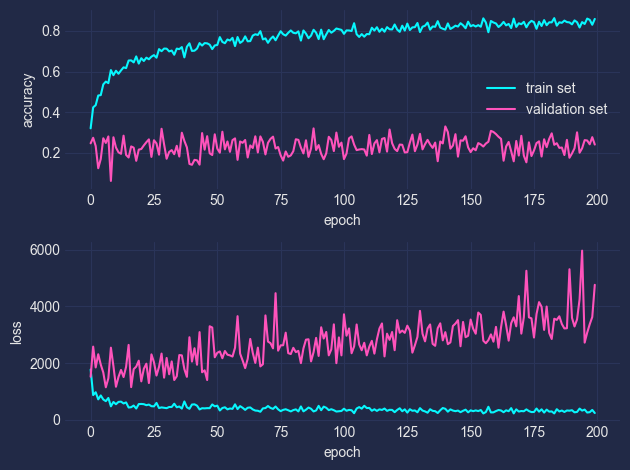

In [36]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['accuracy'],label='train set')
ax[0].plot(history.history['val_accuracy'],label='validation set')
ax[0].set(xlabel='epoch',
          ylabel='accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'],label='train')
ax[1].plot(history.history['val_loss'],label='val')
ax[1].set(xlabel='epoch',
          ylabel='loss')
# ax[1].legend()
fig.tight_layout()

## Model evaluation

In [2]:
Y_pred_test = model.predict(dataset_test)

NameError: name 'model' is not defined

In [1]:
model.evaluate(dataset_test)

NameError: name 'model' is not defined

## Model saving